In [1]:
import torch
from torch import autograd
import torch.distributions as dist

import matplotlib.pyplot as plt
%matplotlib inline

## Classic autograd usage

To declare a torch tensor as a leaf node in a computation graph, use `requires_grad`. Notice the difference:

In [2]:
x = torch.FloatTensor([2.2, 1.1])
x

tensor([2.2000, 1.1000])

In [3]:
x.requires_grad_(True)

tensor([2.2000, 1.1000], requires_grad=True)

A tensor that has `requires_grad=True` has a `.grad` attribute. This is initialized to `None`.

In [4]:
x.grad is None

True

You can see the computation graph being built dynamically! For internal nodes, it shows up as `grad_fn`.

In [5]:
y = x.pow(2)
y

tensor([4.8400, 1.2100], grad_fn=<PowBackward0>)

In [6]:
z = (torch.sin(x) - y).sum()
z

tensor(-4.3503, grad_fn=<SumBackward0>)

Once you've done some computation, you can call `.backward()` on a scalar output to accumulate gradients in the leaf nodes of the graph:

In [7]:
z.backward()
x.grad

tensor([-4.9885, -1.7464])

Calling `z.backward()` again will raise an error. If you want second derivatives, you'll need to explicitly tell it to "retain" the graph.

Also, be careful if you now "reuse" this value of `x`!

In [8]:
(x + 2).sum().backward()
x.grad

tensor([-3.9885, -0.7464])

This value is wrong, because when `.backward()` is called, it does not reset the currently stored `.grad` attribute to zero! Instead, it accumulates more partial derivatives. You can manually zero it out though, to get the expected result. Note that `.zero_()`, and all the methods with underscores, are generally "in-place" operations. You will usually want to avoid these, but in this case it's actually what we want.

In [9]:
x.grad.zero_()
(x + 2).sum().backward()
x.grad

tensor([1., 1.])

## Torch optimizers

There are many optimization tools built into pytorch. Here we will show how to use the `torch.optim.SGD` class to minimize a test function.

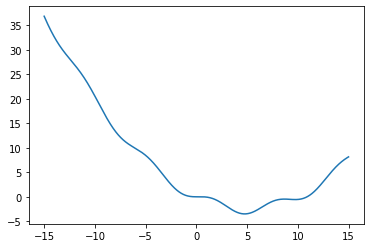

In [10]:
def fn(x):
    return 0.1*x.pow(2) - x + x.sin()

domain = torch.linspace(-15, 15, 1000)
plt.plot(domain, fn(domain));

Most of the time you use gradients in pytorch, particularly for deep learning models, it will be something like the following incantation:

In [11]:
# set initial point
x = torch.tensor(-10.0, requires_grad=True)

# define optimizer
opt = torch.optim.SGD((x, ), lr=0.1, momentum=0.8)

# iterate
N_steps = 30
# track progress
values = []
for _ in range(N_steps):
    # zero the gradients
    opt.zero_grad()
    # forward pass
    y = fn(x)
    # backward pass
    y.backward()
    # save value for reference (`.item()` returns the raw scalar!)
    values.append((x.item(), y.item()))
    # do one optmizer step
    opt.step()


Plot what happened:

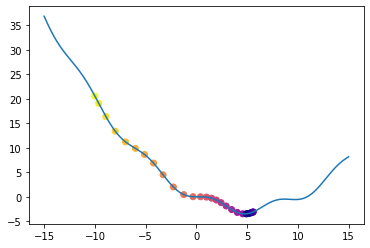

In [12]:
plt.plot(domain, fn(domain));
plt.scatter(torch.FloatTensor(values)[:,0], 
            torch.FloatTensor(values)[:,1], 
            c=torch.linspace(0, 1, len(values)), 
            cmap='plasma_r');

## Plotting whole derivatives

This isn't a very common use-case, but you can do it!

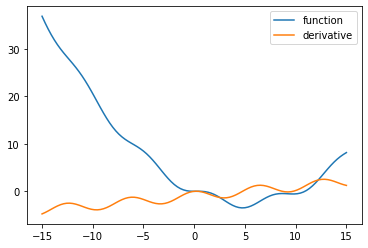

In [13]:
inputs = torch.linspace(-15, 15, 100).requires_grad_(True)
outputs = fn(inputs)

# this is one way to compute the gradient in parallel at each point,
# by passing in `ones` as the starting values everywhere
fn(inputs).backward(gradient=torch.ones_like(outputs))

# When you are doing something that doesn't require the gradients,
# like plotting, then you should wrap your computation in
# `torch.no_grad()`.
with torch.no_grad():
    plt.plot(inputs, outputs)
    plt.plot(inputs, inputs.grad)
    plt.legend(['function', 'derivative', 'y = 0']);


### Note: variable which require gradients can't be cast to numpy

They can be `.detach()`d, or wrap the block of code in `torch.no_grad()`. Of course, this will create a "break" in the computation graph!

In [14]:
outputs.numpy()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [15]:
with torch.no_grad():
    print(outputs.numpy())

[ 3.6849712e+01  3.5449707e+01  3.4145271e+01  3.2947350e+01
  3.1858822e+01  3.0874283e+01  2.9980528e+01  2.9157745e+01
  2.8381340e+01  2.7624153e+01  2.6858955e+01  2.6060921e+01
  2.5209888e+01  2.4292194e+01  2.3301931e+01  2.2241480e+01
  2.1121275e+01  1.9958893e+01  1.8777409e+01  1.7603319e+01
  1.6464123e+01  1.5385807e+01  1.4390483e+01  1.3494385e+01
  1.2706364e+01  1.2027105e+01  1.1449055e+01  1.0957104e+01
  1.0529980e+01  1.0142171e+01  9.7662554e+00  9.3754063e+00
  8.9458265e+00  8.4589233e+00  7.9030032e+00  7.2743306e+00
  6.5774803e+00  5.8249063e+00  5.0358191e+00  4.2344284e+00
  3.4477401e+00  2.7030897e+00  2.0256600e+00  1.4361792e+00
  9.4903660e-01  5.7096785e-01  3.0044299e-01  1.2780565e-01
  3.6152542e-02  2.8747171e-03  1.7166436e-03  5.1696599e-03
 -1.3021469e-02 -7.5466037e-02 -1.9906723e-01 -3.9348143e-01
 -6.6023779e-01 -9.9260157e-01 -1.3761839e+00 -1.7902560e+00
 -2.2096364e+00 -2.6069863e+00 -2.9553020e+00 -3.2303729e+00
 -3.4129908e+00 -3.49069